# Stress state within a prestine ground glacier.

In this code, we'll gain insight into the behaviour of  pristine glaciers that are land terminating and ocean terminating. Mimicking the conditions relevant to grounded glaciers, a free slip condition is applied to the bottom surface, restraining the displacement in the vertical direction. The normal component of the displacement field at the far left edge is restrained to prevent rigid body motion in the horizontal direction. The top surface, representing the atmosphere–ice interface, is defined as a free boundary.

## Step 1: Preprocessing
- Define units: N, m
- Prepare the design basis report

## Step 2: Importing Necessary Libraries

In [1]:
from dolfin import *
import ufl
from helpers import *
from problem_definition import *
from matplotlib import pyplot as plt

%matplotlib inline

## Step 3: Loading the Mesh

In [2]:
mesh = Mesh()
with XDMFFile("mesh/ice.xdmf") as infile:
    infile.read(mesh)

In [3]:
mesh.hmin()

0.14749432650807182

## Step 4: Preparing the sets

In [4]:
support_left = CompiledSubDomain("on_boundary && near(x[0], 0.0, tol)", tol=1e-14)
support_bottom = CompiledSubDomain("on_boundary && near(x[1],0.0, tol)", tol=1e-14)
load_right = CompiledSubDomain("on_boundary && x[1]<= 62.5 && x[0]==500")

mf_line = MeshFunction("size_t", mesh, 1)
load_right.mark(mf_line, 1)

ds = Measure("ds")(subdomain_data=mf_line)

## Step 5: Preparing output file

In [5]:
xdmf = XDMFFile("output/solution.xdmf")
xdmf.parameters["functions_share_mesh"] = True
xdmf.parameters["rewrite_function_mesh"] = False
xdmf.parameters["flush_output"] = True

## Step 6: Defining  spaces

In [6]:
V1 = VectorFunctionSpace(mesh, "CG", 1)
F1 = FunctionSpace(mesh, "CG", 1)

FDG0 = FunctionSpace(mesh, "DG", 0)
TDG0 = TensorFunctionSpace(mesh, "DG", 0)

Calling FFC just-in-time (JIT) compiler, this may take some time.


## Step 7: Define functions

In [7]:
u, v = TrialFunction(V1), TestFunction(V1)
unew, uold = Function(V1, name="disp"), Function(V1, name="disp")
stress_xx, cdf = Function(F1, name="sigma_xx"), Function(F1, name="cdf")

In [8]:
p, q = TrialFunction(F1), TestFunction(F1)
pnew, pold = Function(F1, name="damage"), Function(F1, name="damage")

## Step 8: Material Model

In [9]:
# N, m, Pa
g = 9.81
rho_sea = 1020
E0_ice = 9500e6
nu_ice = 0.35
rho_i_ice = 917 
sigma_c_ice = 0.1185e6 

In [10]:
l = 0.625

In [11]:
ice = MaterialModel(E0_ice, nu_ice, rho_i_ice, sigma_c_ice, 1)

## Step 9: Define supports

In [12]:
bc_sp_x = DirichletBC(V1.sub(0), Constant(0.0), support_left)
bc_sp_x2 = DirichletBC(V1.sub(1), Constant(0.0), support_bottom)
bc_u = [bc_sp_x, bc_sp_x2]

## Step 10: Define Loads


In [14]:
t = Expression(("-(rho_sea*(125/2 -x[1]))", 0), rho_sea=rho_sea*g, degree=1)
# t = Constant((0, 0))
f = Constant((0, -ice.rho * g))

## Step 11: Define the problem

In [14]:
a_disp = inner(degradation(pnew) * ice.stress(u), ice.strain(v)) * dx
L_disp = (1-pnew)*dot(f, v) * dx + dot(t, v) * ds(1)

In [15]:
a_phase = ((1 + cdf) * inner(p, q) + l**2 * inner(grad(p), grad(q))) * dx
L_phase = inner(cdf, q) * dx

## Step 12: Solve 

In [16]:
disp_problem = LinearVariationalProblem(a_disp, L_disp, unew, bc_u)
phase_problem = LinearVariationalProblem(a_phase, L_phase, pnew)

In [17]:
problem = FractureProblem(disp_problem, phase_problem, ice, cdf)
solver = FractureSolver(problem)

In [18]:
prm = solver.parameters
prm["time_start"] = 0.0
prm["time_total"] = 100.0
prm["delta_t"] = 1.0
prm["multi_staggered"]["tolerance"] = 1e-5
prm["multi_staggered"]["maximum_iterations"] = 4

In [19]:
solver.solve(xdmf)

-----------------Time Step----------------------
Calling FFC just-in-time (JIT) compiler, this may take some time.
err - u - 2.335e+00 -- err - phi - 1.798e+00
err - u - 4.685e-03 -- err - phi - 1.899e+00
err - u - 5.687e-03 -- err - phi - 1.996e+00
err - u - 6.633e-03 -- err - phi - 2.099e+00
-----------------Time Step----------------------
err - u - 7.703e-03 -- err - phi - 2.218e+00
err - u - 8.807e-03 -- err - phi - 2.320e+00
err - u - 9.786e-03 -- err - phi - 2.407e+00
err - u - 1.075e-02 -- err - phi - 2.500e+00
-----------------Time Step----------------------
err - u - 1.176e-02 -- err - phi - 2.576e+00
err - u - 1.260e-02 -- err - phi - 2.622e+00
err - u - 1.332e-02 -- err - phi - 2.670e+00
err - u - 1.400e-02 -- err - phi - 2.690e+00
-----------------Time Step----------------------
err - u - 1.465e-02 -- err - phi - 2.699e+00
err - u - 1.522e-02 -- err - phi - 2.699e+00
err - u - 1.571e-02 -- err - phi - 2.685e+00
err - u - 1.595e-02 -- err - phi - 2.658e+00
-----------------T

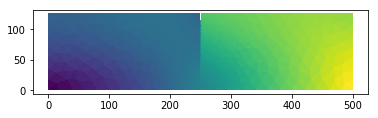

In [20]:
plot(unew, mode="displacement")

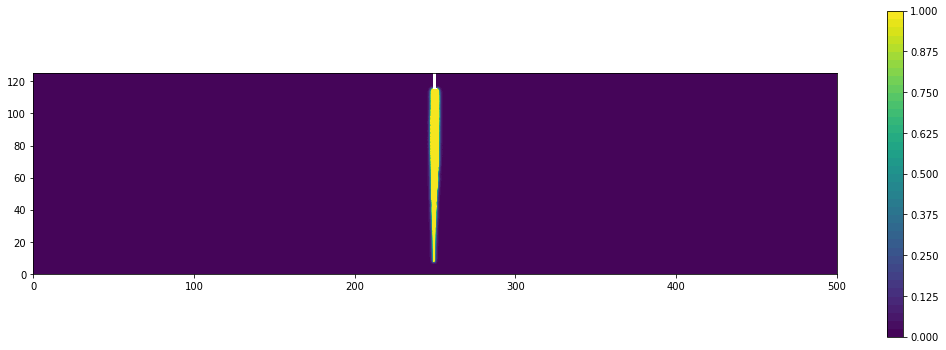

In [21]:
plt.figure(figsize=(18, 6))
c = plot(pnew)
plt.colorbar(c)  # Adds the colorbar
plt.show()

## Step 13: Post processing

In [22]:
stress_xx.assign(project(ice.stress(unew)[0, 0] / 1e6, FDG0))  # N/m2 -> MPa
cdf.assign(project(ice.get_crack_driving_force(unew), FDG0))

Calling FFC just-in-time (JIT) compiler, this may take some time.


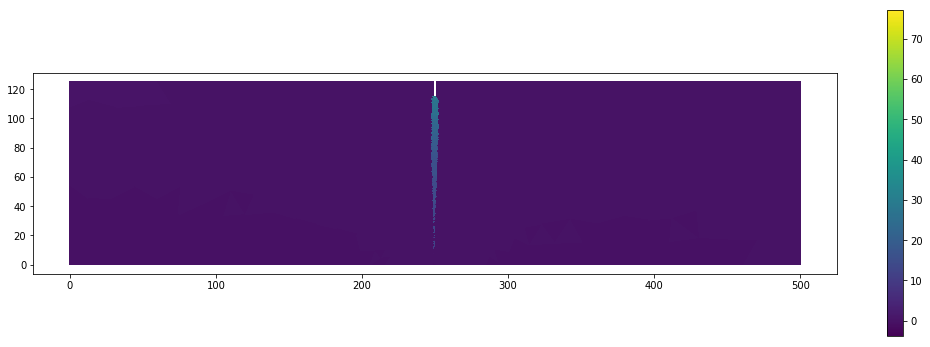

In [23]:
plt.figure(figsize=(18, 6))
c = plot(stress_xx)
plt.colorbar(c)  # Adds the colorbar
plt.show()

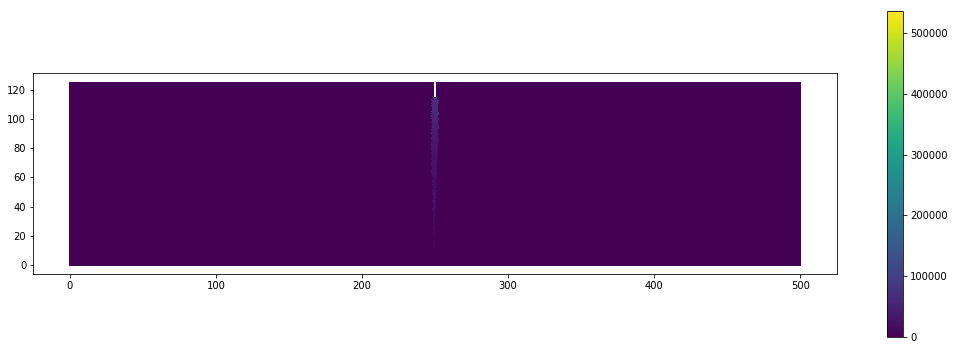

In [24]:
plt.figure(figsize=(18, 6))
c = plot(cdf)
plt.colorbar(c)  # Adds the colorbar
plt.show()

In [25]:
# xdmf.write(unew, 0)
# xdmf.write(stress_xx, 0)
# xdmf.write(cdf, 0)
# xdmf.close()